In [13]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from binarypredictor.datagen import DataGenerator, PolyGenerator

In [14]:
pg = PolyGenerator(4)

x = np.arange(0, 101)/100

pg.add_constraint(np.array([0.9]), 0, 0)
pg.add_constraint(np.array([0.9]), 1, 0)
pg.add_constraint(np.array([0.5]), 0, 5)
pg.add_constraint(np.array([0.1]), 0, 0)
pg.add_constraint(np.array([0.1]), 1, 0)

In [15]:
qg = PolyGenerator(2)

x = np.arange(0, 101)/100

qg.add_constraint(np.array([0.3]), 0, 0)
qg.add_constraint(np.array([0.3]), 1, 0)
qg.add_constraint(np.array([0.5]), 0, 2)

In [16]:
tk = 1313
R = 8.3143

gagfcc=-7209.5+118.2007*tk
gagl=3815.93+109.3029*tk-1.044523e-20*tk**7
glag=gagl-gagfcc;
gaufcc=-15745+225.14*tk
gaul=-3352+215.88*tk-3.5899325e-21*tk**7
glau1=gaul-gaufcc
glau=12552-9.385866*tk

In [17]:
def funcs(xl, xs, tk, a=True, b=False):
    if a:
        gl = (1-xl)*glag+xl*glau1+R*tk*((1-xl)*torch.log(1-xl)+xl*torch.log(xl))+(1-xl)*xl*(-16402+1.14*tk)
        gs = R*tk*((1-xs)*torch.log(1-xs)+xs*torch.log(xs))+(1-xs)*xs*(-15599)
        glxl = 1367.57-0.3622*tk+0.68552975*10**-20*tk**7+R*tk*(-torch.log(1-xl)+torch.log(xl))-xl*(-16402+1.14*tk)+(1-xl)*(-16402+1.14*tk)
        gsxs = R*tk*(-torch.log(1-xs)+torch.log(xs))+31198*xs-15599
    else:
        gl = 2*xl**3 + 20
        glxl = 6*xl**2   
        gs = (xs-3)**3 + xs
        gsxs = 3*(xs-3)**2 + 1
        
    if b: 
        gl = torch.tensor(pg.get_value_at_x(xl.detach().numpy(), 0), requires_grad=True)
        glxl = torch.tensor(pg.get_value_at_x(xl.detach().numpy(), 1), requires_grad=True)
        gs = torch.tensor(qg.get_value_at_x(xs.detach().numpy(), 0), requires_grad=True)
        gsxs = torch.tensor(qg.get_value_at_x(xs.detach().numpy(), 1), requires_grad=True)
    
    return gl, gs, glxl, gsxs

In [18]:
seq1 = nn.Sequential(
    nn.Linear(200, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 2),
    nn.Sigmoid()
    )

seq2 = nn.Sequential(
    nn.Linear(100, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 10),
    nn.Sigmoid()
    )

In [19]:
x = torch.arange(1e-6, 100, step=101/100)/100

In [20]:
a = True
b = False

In [21]:
glx, gsx, glxlx, gsxsx = funcs(x, x, tk, a, b)

In [33]:
print(glx)
print()
print(gsx)
print(torch.hstack((glx, gsx))/1000)

tensor([  -727.6537,  -1483.5604,  -2082.4521,  -2619.4736,  -3114.8406,
         -3578.1465,  -4015.0369,  -4429.2397,  -4823.3975,  -5199.4839,
         -5559.0283,  -5903.2490,  -6233.1382,  -6549.5215,  -6853.0908,
         -7144.4395,  -7424.0801,  -7692.4551,  -7949.9551,  -8196.9248,
         -8433.6699,  -8660.4619,  -8877.5488,  -9085.1484,  -9283.4619,
         -9472.6680,  -9652.9326,  -9824.4033,  -9987.2188, -10141.5000,
        -10287.3652, -10424.9121, -10554.2422, -10675.4395, -10788.5830,
        -10893.7461, -10990.9961, -11080.3906, -11161.9863, -11235.8320,
        -11301.9717, -11360.4453, -11411.2881, -11454.5303, -11490.1973,
        -11518.3135, -11538.8965, -11551.9619, -11557.5195, -11555.5791,
        -11546.1396, -11529.2061, -11504.7715, -11472.8320, -11433.3730,
        -11386.3809, -11331.8379, -11269.7207, -11200.0049, -11122.6562,
        -11037.6426, -10944.9238, -10844.4551, -10736.1875, -10620.0664,
        -10496.0312, -10364.0176, -10223.9512, -100

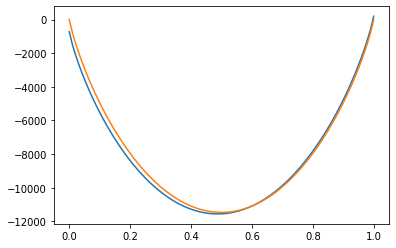

In [22]:
plt.plot(x, glx.detach().numpy())
plt.plot(x, gsx.detach().numpy())

In [23]:
class custom_loss(nn.Module):
    def __init__(self):
        super(custom_loss, self).__init__()

        # Initialize parameters
        self.a = nn.Parameter(torch.tensor(0.1), requires_grad=True)
        
    def forward(self, c1l, c1r, c2l, c2r):
        return self.a * nn.MSELoss()(c1l, c1r) + (1 - self.a) * nn.MSELoss()(c2l, c2r)

In [34]:
#loss_fn = nn.MSELoss()

opt1 = torch.optim.Adam(seq1.parameters(), lr=0.00001/2)
opt2 = torch.optim.Adam(seq2.parameters(), lr=0.00001/2)
nr_epochs = 20000

loss_fn = custom_loss()

for i in range(nr_epochs):
    inp = torch.tensor([tk/1000], dtype=torch.float)
    xl, xs = seq1(torch.hstack((glx, gsx)).float()/1000)#, seq2(gsx.float()/1000)

    gl, gs, glxl, gsxs = funcs(xl, xs, tk, a=a, b=b)
    
    opt1.zero_grad(), opt2.zero_grad()
    #loss = loss_fn(gl - xl * glxl, gs - xs * gsxs) + loss_fn(gsxs, glxl)
    loss = loss_fn(gl - xl * glxl, gs - xs * gsxs, gsxs, glxl)
    if i % (nr_epochs / 100) == 0:
        print(loss)
    loss.backward()
    opt1.step(), opt2.step()
    #print()

tensor(41871812., grad_fn=<AddBackward0>)
tensor(56252.7695, grad_fn=<AddBackward0>)
tensor(826.3285, grad_fn=<AddBackward0>)
tensor(826.1981, grad_fn=<AddBackward0>)
tensor(826.0547, grad_fn=<AddBackward0>)
tensor(825.8832, grad_fn=<AddBackward0>)
tensor(825.6785, grad_fn=<AddBackward0>)
tensor(825.4075, grad_fn=<AddBackward0>)
tensor(825.1711, grad_fn=<AddBackward0>)
tensor(824.8170, grad_fn=<AddBackward0>)
tensor(824.4400, grad_fn=<AddBackward0>)
tensor(823.9856, grad_fn=<AddBackward0>)
tensor(823.4084, grad_fn=<AddBackward0>)
tensor(822.8098, grad_fn=<AddBackward0>)
tensor(822.1285, grad_fn=<AddBackward0>)
tensor(821.3560, grad_fn=<AddBackward0>)
tensor(820.4435, grad_fn=<AddBackward0>)
tensor(819.4537, grad_fn=<AddBackward0>)
tensor(818.3813, grad_fn=<AddBackward0>)
tensor(817.1226, grad_fn=<AddBackward0>)
tensor(815.7252, grad_fn=<AddBackward0>)
tensor(814.1904, grad_fn=<AddBackward0>)
tensor(812.4620, grad_fn=<AddBackward0>)
tensor(810.5052, grad_fn=<AddBackward0>)
tensor(808.39

In [35]:
print()
print(xl)
print(xs)
print()
print(glxl)
print(gsxs)
print()
print(gl - xl * glxl)
print(gs - xs * gsxs)


tensor(0.5902, grad_fn=<UnbindBackward0>)
tensor(0.6008, grad_fn=<UnbindBackward0>)

tensor(7609.9995, grad_fn=<AddBackward0>)
tensor(7610.5762, grad_fn=<SubBackward0>)

tensor(-15658.6709, grad_fn=<SubBackward0>)
tensor(-15657.1826, grad_fn=<SubBackward0>)
